## Bienvenidos!

En estos notebooks vamos a correr una red neuronal para interpretar texto.

En esta primer celda importamos todas las librerías que necesitaremos para ejecutar un ejemplo de red Neuronal

In [13]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.


from __future__ import print_function
import collections
import math
import tensorflow as tf
import numpy as np
import os
import random
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Esta celda nos permite descargar un dataset (text8.zip) el cual contiene muchísimo texto en un formato similar
al de un archivo ".txt" la función se encarga de descargarlo y de evaluar la integridad del mismo dataset.

In [14]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Esta celda nos permite leer los datos a fin de optener una lista de palabras, donde cada posición de la lista es una de las
palabras que se encuentra en el dataset.

In [15]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


En  la siguiente celda definimos una función para crear nuestro dataset, la idea detrás de esta función es asignar un índice
único para cauda una de las palabras, para ello se usa una función de collections que nos extrae una lista de pares o tuplas
de la forma (palabras, frecuencia) con esto creamos una lista de indices, garantizando que no repitamos el indice de una de las palabras
también extraemos dos diccionarios que nos permiten acceder a una palabra dada su indice o viceversa.

In [16]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]


La siguiente celda nos muestra una función que genera un pequeño pedazo de entrenamiento para la red neuronal,
las entradas son el tamaño del pedazo o "batch" y una ventana.
La idea de esta función es devolver unos datos de entrenamiento junto con sus labels.
Sea $W$ un texto, y $W_{i}$ un índice único asociado a una palabra, entonces podríamos representar todo nuestro texto como:
$$W=W_1W_2W_3...W_n$$
$entrada = (W_1,W_3)$  $objetivo = W_2$

In [17]:
data_index = 0

# skip_window: int : How many words to consider left and right.
def generate_cbow_batch(batch_size, skip_window):
  global data_index
#   assert batch_size % num_skips == 0
#   assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size, skip_window*2), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size,1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
#   buffer = []
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  
  for i in range(batch_size):
    batch[i] = list(buffer)[:skip_window] + list(buffer)[skip_window+1:]
    labels[i] = buffer[skip_window]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
    
  return batch, labels
batch,labels = generate_cbow_batch(128,1)

Pares de palabras de entrada de la forma: }
    $$(W_i, W_{i+2})$$
donde $i = 1,2,3... n-2$

En la siguiente celda se muestran los 10 primeros pares de palabras formados, nótese que no se muestra la palabra en sí,
sino el indice único de cada palabra.

In [20]:
display(batch[:10])


array([[5234,   12],
       [3081,    6],
       [  12,  195],
       [   6,    2],
       [ 195, 3134],
       [   2,   46],
       [3134,   59],
       [  46,  156],
       [  59,  128],
       [ 156,  742]])

El objetivo, target o "label" es una indice único asociado a una única palabra de la forma:
    $$W_{i+1}$$
    donde $i = 1, 2, 3, ..., n-2$
    
En la siguiente celda se muestran los 10 primeros labels de nuestro dataset de prueba.

In [24]:
display(labels[:10])

array([[3081],
       [  12],
       [   6],
       [ 195],
       [   2],
       [3134],
       [  46],
       [  59],
       [ 156],
       [ 128]])

In [31]:
for i in range (0 , 10 ):
    print ('input: ({0},{1}) -- label:({2}) -- sentence: {0} {2} {1}'.format(reverse_dictionary[batch[i,0]],
                                                                               reverse_dictionary[batch[i,1]],
                                                                               reverse_dictionary[labels[i][0]]))

input: (anarchism,as) -- label:(originated) -- sentence: anarchism originated as
input: (originated,a) -- label:(as) -- sentence: originated as a
input: (as,term) -- label:(a) -- sentence: as a term
input: (a,of) -- label:(term) -- sentence: a term of
input: (term,abuse) -- label:(of) -- sentence: term of abuse
input: (of,first) -- label:(abuse) -- sentence: of abuse first
input: (abuse,used) -- label:(first) -- sentence: abuse first used
input: (first,against) -- label:(used) -- sentence: first used against
input: (used,early) -- label:(against) -- sentence: used against early
input: (against,working) -- label:(early) -- sentence: against early working


# Implementación del modelo CBOW en tensorflow

In [33]:
# CBOW model

batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  # note the different input dimensions for the CBOW model
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size,skip_window*2])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  # note the sum over the context embeddings for the CBOW model
  #Búsqueda de los parámetros dados en el training batch
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  #Realiza una suma a través de las filas
  embed = tf.reduce_sum(embed, 1)

  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [43]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_cbow_batch(
      batch_size, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  embedding_vector = embeddings.eval()
  final_embeddings = normalized_embeddings.eval()
  

Initialized
Average loss at step 0: 7.767956
Nearest to at: vibrating, lingus, radars, sand, atop, seclusion, hereford, enthusiast,
Nearest to called: kirwan, bopp, falklands, struct, elphinstone, panyu, juli, enlist,
Nearest to by: pistons, hysteria, handlebar, therapists, trevelyan, borges, dreamed, mishap,
Nearest to is: dekalb, cabrera, dlp, farley, circumcisions, elite, wa, surfers,
Nearest to d: silesia, unionist, complained, pledges, motherboards, doesburg, automorphism, norfolk,
Nearest to nine: peking, wimp, putnam, roasting, meleon, angleton, nice, livelihood,
Nearest to and: why, charges, revolving, terran, fax, anthem, receding, bertrand,
Nearest to only: antipsychotic, lords, pacino, seismic, argumentation, schiller, weissmuller, plated,
Nearest to new: spare, lattice, freer, thymus, havas, reappearance, nephritis, proclaimed,
Nearest to there: clutches, mcvie, inscription, ejective, capo, folding, authority, novelists,
Nearest to people: probabilities, decoys, neg, contra

Average loss at step 52000: 2.771861
Average loss at step 54000: 2.864794
Average loss at step 56000: 2.778695
Average loss at step 58000: 2.830631
Average loss at step 60000: 2.873669
Nearest to at: during, in, near, sibley, pinstripes, inflections, within, genetical,
Nearest to called: named, known, kirwan, considered, desilu, celebrated, see, awarded,
Nearest to by: through, simo, against, when, abdominal, echolocation, during, oireachtas,
Nearest to is: was, contains, makes, becomes, has, are, does, appears,
Nearest to d: b, motherboards, derivations, drags, coaches, fruitless, insoluble, stadt,
Nearest to nine: eight, seven, six, five, four, three, zero, two,
Nearest to and: or, but, including, though, although, interconnects, while, than,
Nearest to only: probably, actually, employs, begun, knightly, either, xc, enacting,
Nearest to new: ruble, spare, thymus, chew, dealerships, classic, safeguarded, resulting,
Nearest to there: they, she, it, often, he, we, still, unclear,
Neares

In [52]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

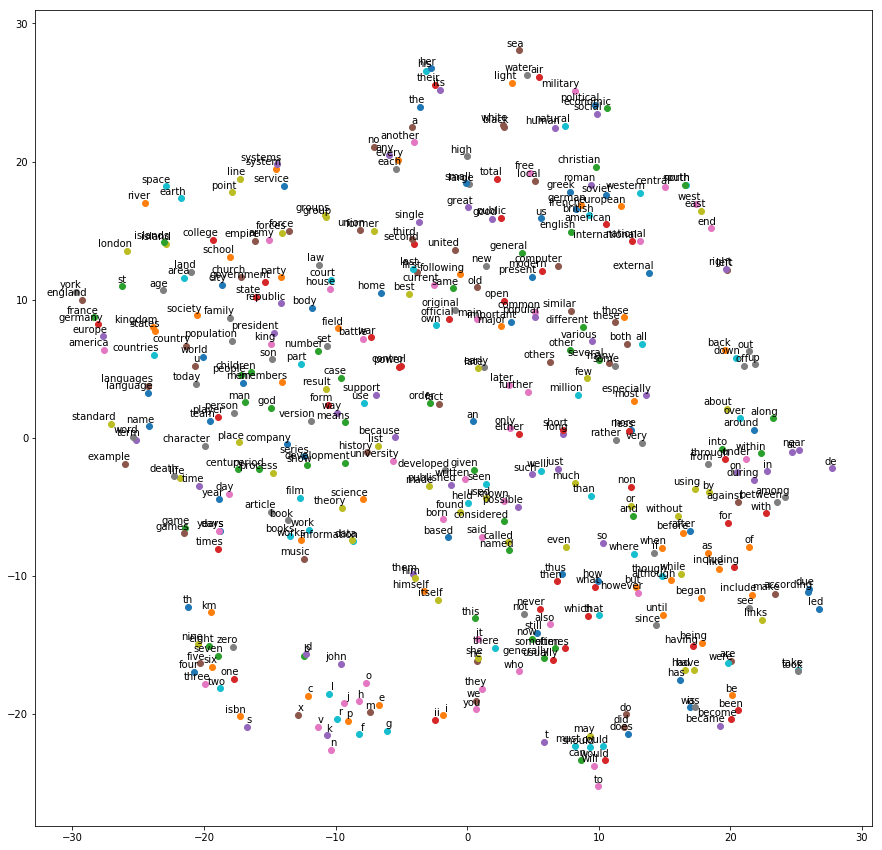

In [53]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)